In [1]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

# Modellpfad festlegen

In [2]:
model_path = "models/standart_model_with_normalisation.pt"

# Daten herunterladen

In [3]:
data_download("flickr8k")

Data already exi sts at flickr8k


# Modell mit Normalisierung

## Modell laden

In [4]:
# load model
model_stats = torch.load(model_path, map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [5]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, captions_path="flickr8k/captions.txt", vocabulary=model_stats['embedding'].vocabulary ,captions=captions, embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=True, image_folder_path="flickr8k")
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76
transformed_images folder already exists. No preprocessing necessary.


## Datensplit und DataLoader

In [6]:
training_images, test_images = train_test_split(caption_preprocessor.captions.image.unique(), test_size=0.15, random_state=42)
training_data = caption_preprocessor.captions[caption_preprocessor.captions.image.isin(training_images)]
test_data = caption_preprocessor.captions[caption_preprocessor.captions.image.isin(test_images)]

In [7]:
# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding, image_folder="flickr8k")
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding, image_folder="flickr8k")

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [67]:
def visualize_model_results(model, df:pd.DataFrame, n_samples=8):
    sample = df.sample(n_samples)
    scores = []
    for i, image_path in enumerate(sample.image.values):
        input = torchvision.io.read_image("flickr8k/transformed_images/" + image_path).float()
        image = Image.open("flickr8k/images/" + image_path)
        plt.imshow(image)
        plt.show()
        print("predicted")
        predicted_caption = model.forward(input.unsqueeze(0))
        predicted_caption = np.delete(predicted_caption, np.where(predicted_caption == '<PAD>'))
        predicted_caption = np.delete(predicted_caption, np.where(predicted_caption == '<EOS>'))
        predicted_caption = np.delete(predicted_caption, np.where(predicted_caption == '<SOS>'))
        print(20*"-")
        print(" ".join(predicted_caption))
        print("caption")
        print(20*"-")
        caption = np.array(eval(sample["caption"].iloc[i]))
        caption = np.delete(caption, np.where(caption == '<PAD>'))
        caption = np.delete(caption, np.where(caption == '<EOS>'))
        caption = np.delete(caption, np.where(caption == '<SOS>'))

        print(" ".join(caption))
        score = nltk.translate.bleu_score.sentence_bleu([caption], predicted_caption, weights=(1,0,0,0), smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
        print("BLEU-1 Score: ", score)
        scores.append(score)
    print("Average BLEU-1 Score: ", np.mean(np.array(scores)))


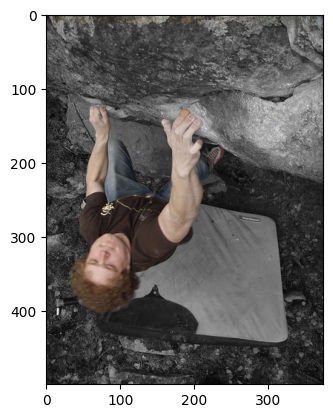

predicted
--------------------
a man is climbing a rocky mountain
caption
--------------------
a man with a dark brown shirt is climbing up a rocky elevation
BLEU-1 Score:  0.36374815343738565


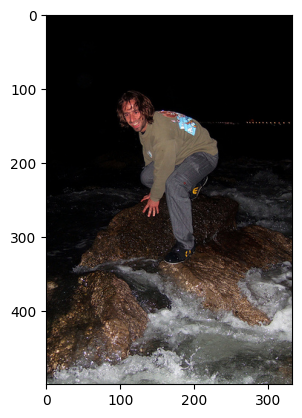

predicted
--------------------
a man crouching down on some rocks in the ocean
caption
--------------------
a man is standing on some rocks while waves lap around him
BLEU-1 Score:  0.40936537653899097


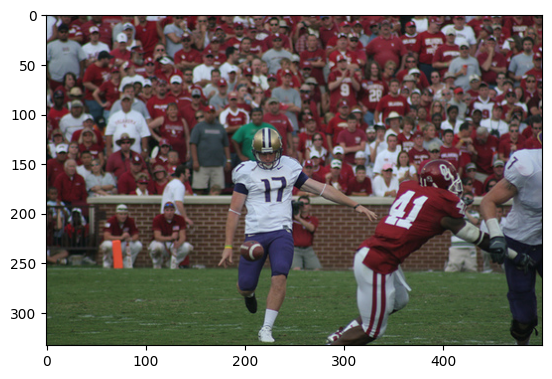

predicted
--------------------
a male wearing a football uniform kicking a football during a football game
caption
--------------------
a man punting a football as fans from the opposing team watch in the background
BLEU-1 Score:  0.19786244288317878


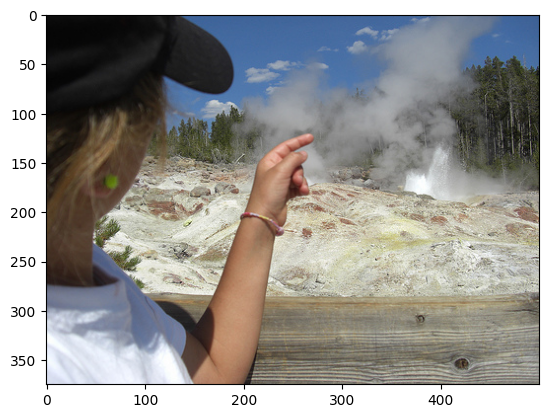

predicted
--------------------
a woman in a white tshirt points at a geyser
caption
--------------------
the girl is pointing at a geyser
BLEU-1 Score:  0.3


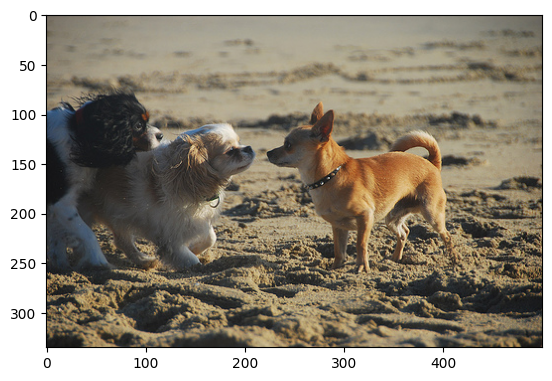

predicted
--------------------
three small dogs stand in the sand and stare at each other
caption
--------------------
two small dogs facing a third dog
BLEU-1 Score:  0.16666666666666669


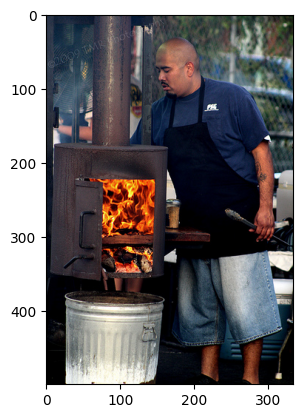

predicted
--------------------
a man operating a furnace
caption
--------------------
the man wearing blue jean shorts is grilling
BLEU-1 Score:  0.10976232721880529


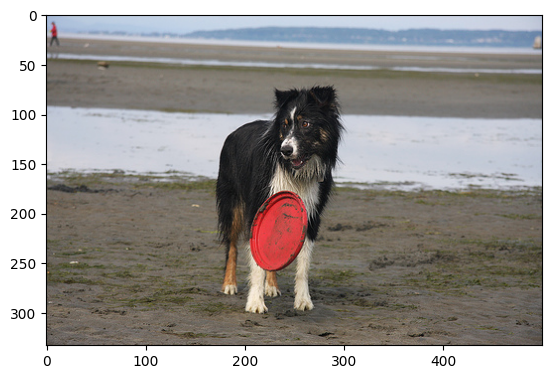

predicted
--------------------
a dog with a red frisbee flying in the air
caption
--------------------
the black dog is dropping a red disc on a beach
BLEU-1 Score:  0.45241870901797976


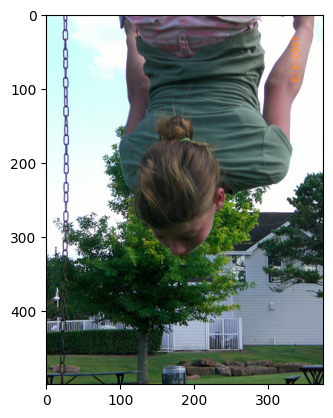

predicted
--------------------
a girl in a green shirt is hanging upside down
caption
--------------------
a girl in a green shirt is hanging upside down
BLEU-1 Score:  1.0
Average BLEU-1 Score:  0.3749779594703759


In [71]:
visualize_model_results(model, training_data)